### Generating Animated Map with `folium`

https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/Plugins.ipynb#Timestamped-GeoJSON

In [ ]:
import pandas as pd
import folium
from folium import plugins
import requests

pd.options.display.max_columns = None

In [ ]:
# df = pd.read_csv('https://earthquake.usgs.gov/earthquakes/'
#                  'feed/v1.0/summary/2.5_day.csv')
df = pd.read_csv('https://earthquake.usgs.gov/earthquakes/'
                 'feed/v1.0/summary/2.5_month.csv')

# df['time'] = pd.to_datetime(df['time'], utc=True)

df.head()

In [ ]:
# get faults
r = requests.get('https://raw.githubusercontent.com/'
                 'fraxen/tectonicplates/master/GeoJSON/'
                 'PB2002_boundaries.json')

fault_features = r.json()['features']

# for feature in fault_features:
#     feature['properties']['color'] = 'red'

In [ ]:
fault_features

In [ ]:
with open("./data/PB2002_boundaries.json", "r") as read_file:
    fault_feats = json.load(read_file)

In [ ]:
{"features": {"features": [{"geometry": {"coordinates": [[-0.4379, -54.8518], [-0.038826, -54.6772], [0.443182, -54.4512], [0.964534, -54.8322], [1.69481, -54.399], [2.35975, -54.0374], [3.02542, -53.6507], [3.36894, -53.8341], [3.95638, -54.1267], [4.41458, -54.4303], [4.82661, -54.1616], [5.08372, -54.3093], [5.49469, -54.5429], [6.18373, -54.1145], [6.6254, -53.8142], [7.23729, -54.1012], [7.77235, -54.396]], "type": "LineString"}, "properties": {"LAYER": "plate boundary", "Name": "AF-AN", "PlateA": "AF", "PlateB": "AN", "Source": "Mueller et al. [1987]", "Type": ""}, "type": 

In [ ]:
{
    'type': 'FeatureCollection',
    'features': fault_features,
}

In [ ]:
features = [
    {
        'type': 'Feature',
        'geometry': {
            'type': 'Point',
            'coordinates': [r['longitude'], r['latitude']],
        },
        'properties': {
            'time': r['time'][0:-1],
            'popup': (
                f"<strong>Time:</strong> {r['time']}<br>"
                f"<strong>Place:</strong> {r['place']}<br>"
                f"<strong>Magnitude:</strong> {r['mag']} {r['magType']}<br>"
                f"<strong>Depth:</strong> {r['depth']}<br>"
            ),
            'icon': 'circle',
            'iconstyle': {
                'fillOpacity': 0.5,
                'stroke': 0,
                'radius': r['mag'] * 2.5
            },
        }
    } for i, r in df.iterrows()
]

m = folium.Map(
#     location=()
    tiles='CartoDBpositron',
#     zoom_start=1,
#     no_wrap=True,
    min_zoom=1.5,
    max_zoom=5,
    world_copy_jump=True,
)

# add faults
folium.GeoJson(
    {
        'type': 'FeatureCollection',
        'features': fault_features,
    },
    style_function = lambda x: {
        'color': 'red',
        'weight': 0.5,
    }
).add_to(m)

plugins.TimestampedGeoJson(
    {
        'type': 'FeatureCollection',
        'features': features
    },
    period='PT6H', # six hour
    time_slider_drag_update=True,
    duration='PT12H',
    date_options='YYYY-MM-DD HH UTC'
).add_to(m)

folium.plugins.Fullscreen(
    position='topright',
    force_separate_button=True,
).add_to(m)

# m.save('earthquakes.html')
m

In [ ]:
# from IPython.display import IFrame
# IFrame('earthquakes_2.5_day.html', width='100%', height=500)

### Pulling Data from USGS

https://earthquake.usgs.gov/fdsnws/event/1/

In [ ]:
import requests
import pandas as pd
from io import StringIO

pd.options.display.max_columns = None

payload = {
    'format': 'csv', 
#     'starttime': None,  # default last 30 days
#     'endtime': '2019-06-03',  # default now
    'minmagnitude': 0,  # default null
    'limit': None,  # default null, returns 404 over 20,000
}
url = 'https://earthquake.usgs.gov/fdsnws/event/1/query'
r = requests.get(url, params=payload)

r.url

df = pd.read_csv(StringIO(r.text))
print(df.shape)
df.head()

### Damage Data
from https://www.ngdc.noaa.gov/nndc/struts/form?t=101650&s=1&d=1

> The Significant Earthquake Database contains information on destructive earthquakes from 2150 B.C. to the present that meet at least one of the following criteria: 
> * Moderate damage (approximately $1 million or more)
> * 10 or more deaths
> * Magnitude 7.5 or greater
> * Modified Mercalli Intensity X or greater
> * the earthquake generated a tsunami

In [ ]:
dmg = pd.read_csv('https://www.ngdc.noaa.gov/nndc/struts/results?'
                  'type_0=Exact&query_0=$ID&t=101650&s=13&d=189&dfn=signif.txt',
                  sep='\t')

In [ ]:
dmg.describe()

### Contour Plot

One nice way to display likelihoods of earthquake, once we have them

https://www.tjansson.dk/2018/10/contour-map-in-folium/

In [ ]:
import numpy as np
import pandas as pd
import folium
import branca
from folium import plugins
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import geojsoncontour
import scipy as sp
import scipy.ndimage
 
# Setup
temp_mean = 12
temp_std  = 2
debug     = False
 
# Setup colormap
colors = ['#d7191c',  '#fdae61',  '#ffffbf',  '#abdda4',  '#2b83ba']
vmin   = temp_mean - 2 * temp_std
vmax   = temp_mean + 2 * temp_std
levels = len(colors)
cm     = branca.colormap.LinearColormap(colors, vmin=vmin, vmax=vmax).to_step(levels)
 
# Create a dataframe with fake data
df = pd.DataFrame({
    'longitude':   np.random.normal(11.84,     0.15,     1000),
    'latitude':    np.random.normal(55.55,     0.15,     1000),
    'temperature': np.random.normal(temp_mean, temp_std, 1000)})
 
# The original data
x_orig = np.asarray(df.longitude.tolist())
y_orig = np.asarray(df.latitude.tolist())
z_orig = np.asarray(df.temperature.tolist())
 
# Make a grid
x_arr          = np.linspace(np.min(x_orig), np.max(x_orig), 500)
y_arr          = np.linspace(np.min(y_orig), np.max(y_orig), 500)
x_mesh, y_mesh = np.meshgrid(x_arr, y_arr)
 
# Grid the values
z_mesh = griddata((x_orig, y_orig), z_orig, (x_mesh, y_mesh), method='linear')
 
# Gaussian filter the grid to make it smoother
sigma = [5, 5]
z_mesh = sp.ndimage.filters.gaussian_filter(z_mesh, sigma, mode='constant')
 
# Create the contour
contourf = plt.contourf(x_mesh, y_mesh, z_mesh, levels, alpha=0.5, colors=colors, linestyles='None', vmin=vmin, vmax=vmax)
 
# Convert matplotlib contourf to geojson
geojson = geojsoncontour.contourf_to_geojson(
    contourf=contourf,
    min_angle_deg=3.0,
    ndigits=5,
    stroke_width=1,
    fill_opacity=0.5)
 
# Set up the folium plot
geomap = folium.Map([df.latitude.mean(), df.longitude.mean()], zoom_start=10, tiles="cartodbpositron")
 
# Plot the contour plot on folium
folium.GeoJson(
    geojson,
    style_function=lambda x: {
        'color':     x['properties']['stroke'],
        'weight':    x['properties']['stroke-width'],
        'fillColor': x['properties']['fill'],
        'opacity':   0.6,
    }).add_to(geomap)
 
# Add the colormap to the folium map
cm.caption = 'Temperature'
geomap.add_child(cm)
 
# Fullscreen mode
plugins.Fullscreen(position='topright', force_separate_button=True).add_to(geomap)
 
# Plot the data
# geomap.save(f'data/folium_contour_temperature_map.html'
geomap

# Conclusions and Next Steps from Research

* Download ~20 years of data
* Group the world into regions - group by seismic properties? or a grid? do these seismic region groupings already exist?
* for each region, determine how complete USGS datasets are based on Gutenberg–Richter law and compute the cutoff

## Iteratively Download USGS Data

In [7]:
from dateutil.parser import parse
import requests
import pandas as pd
from io import StringIO

pd.options.display.max_columns = None

def dl_quake_data(start_date, end_date, page_limt=10000):
    start_date = parse(start_date).isoformat()
    end_date = parse(end_date).isoformat()
    payload = {
        'format': 'csv',
        'starttime': start_date,
        'endtime': end_date,
        'minmagnitude': 2,
        'limit': page_limt,
        'orderby': 'time-asc',
    }
    url = 'https://earthquake.usgs.gov/fdsnws/event/1/query'
    r = requests.get(url, params=payload)
    
    if r.status_code != 200:
        print('Error', r.status_code, r.url)
        return False
    
    df = pd.read_csv(StringIO(r.text))
    
    dt_min = df['time'].iloc[0]
    dt_max = df['time'].iloc[-1]
    
    fn = (f'{parse(dt_min).strftime("%Y-%m-%d")}_'
          f'{parse(dt_max).strftime("%Y-%m-%d")}')
    df.to_csv(f'data/{fn}.csv', index=False)
    
    print(fn)
    
    if len(df) == page_limt:
         dl_quake_data(start_date=dt_max,
                       end_date=end_date)
    
    return True

In [8]:
# done '1999-01-01' to '2019-01-01'
# dl_quake_data('1999-01-01', '2009-01-01', 10000)

In [11]:
from pathlib import Path

dfs = []
for csv in Path('data').iterdir():
    dfs.append(pd.read_csv(csv))
    
df = pd.concat(dfs)
df['time'] = pd.to_datetime(df['time'])
df['updated'] = pd.to_datetime(df['updated'])

In [10]:
df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,id,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,1999-01-01T01:02:39.860Z,-35.591,-71.745,96.4,4.1,md,NaN,NaN,NaN,NaN,us,usp00090ek,2014-11-07T01:06:43.789Z,"Maule, Chile",earthquake,NaN,NaN,NaN,NaN,reviewed,guc,guc
1,1999-01-01T01:35:07.060Z,21.681,143.124,310.4,4.3,mb,NaN,NaN,NaN,1.03,us,usp00090em,2014-11-07T01:06:44.298Z,Mariana Islands region,earthquake,NaN,NaN,NaN,11.0,reviewed,us,us
2,1999-01-01T02:03:26.520Z,-23.440,179.986,550.0,4.3,mb,NaN,NaN,NaN,0.77,us,usp00090en,2014-11-07T01:06:44.331Z,south of the Fiji Islands,earthquake,NaN,NaN,NaN,13.0,reviewed,us,us
3,1999-01-01T02:09:07.300Z,40.258,27.902,9.0,2.8,md,NaN,NaN,NaN,NaN,us,usp00090ep,2014-11-07T01:06:44.363Z,western Turkey,earthquake,NaN,NaN,NaN,NaN,reviewed,isk,isk
4,1999-01-01T03:02:30.570Z,-10.758,117.822,33.0,4.2,mb,NaN,NaN,NaN,1.24,us,usp00090eq,2014-11-07T01:06:44.372Z,"south of Sumbawa, Indonesia",earthquake,NaN,NaN,NaN,4.0,reviewed,us,us


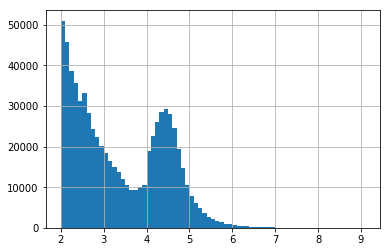

In [5]:
df['mag'].hist(bins=int((df.mag.max() - df.mag.min()) * 10));

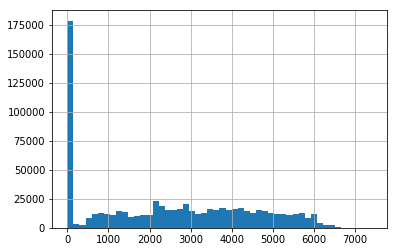

In [7]:
(df['updated'] - df['time']).dt.days.hist(bins=50);

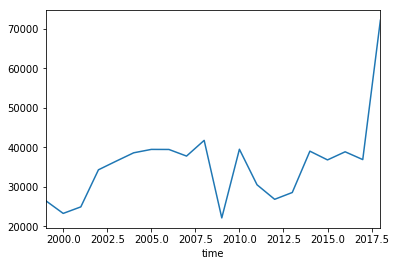

In [8]:
df.groupby(df['time'].dt.year)['id'].count().plot();

In [9]:
df.shape

(714238, 22)

In [22]:
# import hdbscan
# downsamp = df[['latitude', 'longitude']].sample(frac=0.125)
# clusterer = hdbscan.HDBSCAN(metric='haversine')
# clusterer.fit(downsamp)

## Generate Earth Grid
https://en.wikipedia.org/wiki/Geographic_coordinate_system#3D_Cartesian_coordinates

**Potential Improvements:** 

* Define these regions algorithmically (like sklearn.clusters.DBSCAN, [clusterpy](https://github.com/clusterpy/), [Moran'sI](https://en.wikipedia.org/wiki/Moran's_I)) based on earthquake characteristics in the regions
* [Use extant domain research](https://www.researchgate.net/publication/260702383_A_detailed_seismic_zonation_model_for_shallow_earthquakes_in_the_broader_Aegean_area)

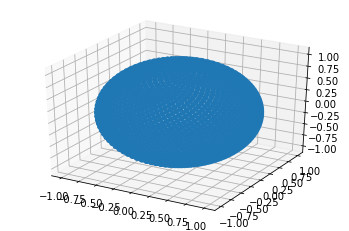

In [395]:
# roughly equidistant points on (cartesian) sphere
#https://stackoverflow.com/a/44164075/11208892
import numpy as np
import mpl_toolkits.mplot3d
import matplotlib.pyplot as plt

num_pts = 3000
indices = np.arange(0, num_pts, dtype=float) + 0.5

phi = np.arccos(1 - 2*indices/num_pts)
theta = np.pi * (1 + 5**0.5) * indices

x = np.cos(theta) * np.sin(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(phi)

plt.figure().add_subplot(111, projection='3d').scatter(x, y, z);
plt.show();

In [396]:
# store as lat/lon, ignoring that the earth is not a sphere
# https://stackoverflow.com/questions/1185408/converting-from-longitude-latitude-to-cartesian-coordinates
clust_df = pd.DataFrame({'clust_lat': 180 * np.arcsin(z / 1) / np.pi, 
                         'clust_lon': 180 * np.arctan2(y, x) / np.pi})
clust_df['clust_id'] = clust_df.index

### Assign Quake Events to Cluster Centers

In [63]:
from sklearn.neighbors import DistanceMetric

dist = DistanceMetric.get_metric('haversine') # requires radian inputs

clust_rads = clust_df[['clust_lat', 'clust_lon']] * np.pi / 180
quake_rads = df[['latitude', 'longitude']] * np.pi / 180

nearest_centers = []
step = 10000
i = 0
while i < quake_events.shape[0]:
    print(round(i/quake_events.shape[0], 3), '%')
    dists = dist.pairwise(quake_rads[i:i+step], clust_rads)
    indices = np.argmin(dists, axis=1)
    nearest_centers.append(clust_centers[indices]) 
    i += step
    
nearest_centers = np.vstack(nearest_centers)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [178]:
df['clust_lat'], df['clust_lon'] = np.nan, np.nan
df[['clust_lat', 'clust_lon']] = 180 * nearest_centers / np.pi

In [182]:
df = df.merge(clust_df, on=['clust_lat', 'clust_lon'])

### Filter to clusters with >= 2000 observations

In [397]:
clust_cnts = df.groupby(['clust_id']).size()
clust_cnts = clust_cnts.loc[clust_cnts >= 2000]

clust_df = clust_df.loc[clust_df['clust_id'].isin(clust_cnts.index)]
df = df.loc[df['clust_id'].isin(clust_cnts.index)]

### Map Cluster Sizes

In [376]:
import folium
import folium.plugins

m = folium.Map(tiles='CartoDBpositron')
clust_cnts = df.groupby(['clust_id', 'clust_lat', 'clust_lon']).size()

for i, v in clust_cnts.items():
    folium.CircleMarker(
        i[1:], 
        radius=np.sqrt((v/100) / np.pi) * 2,
        fill=True,
        fill_opacity=0.5,
        stroke=0,
        popup=f"id:{i[0]}<br>events: {v}",
    ).add_to(m)

folium.plugins.Fullscreen(
    position='topright',
    force_separate_button=True,
).add_to(m)

m

### Identify Cut-Off Magnitude for Each Node, `M_c`

Ideally, we'd use some newfangled [Bayesian methods](https://medium.com/the-history-risk-forecast-of-perils/exploring-the-fascinating-world-of-incomplete-seismicity-data-part-i-ii-bayesian-inference-386338b43b71), but for proof-of-concept, I'll use mode.

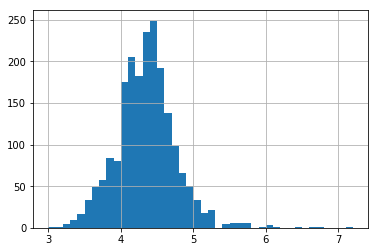

In [368]:
data = df.loc[df['clust_id']==554]

data['mag'].hist(bins=int((data['mag'].max() - data['mag'].min()) * 10));

In [347]:
# Line of best fit iterative method
from sklearn.linear_model import LinearRegression

best_score = 0
best_m_c, a, b = [None] * 3

for M_c in np.arange(data['mag'].min(), 5.0, 0.1):
    counts = data.loc[data['mag'] >= M_c].groupby(['mag']).size()
    val_range = np.arange(counts.index.min(), counts.index.max(), 0.1)
#     unobserved = set(round(x, 2) for x in val_range) - set(counts.index)
#     counts = counts.append(pd.Series(data=0, index=unobserved)) + 1
    counts = counts.sort_index()
    X = np.array(counts.index).reshape(-1, 1)
    y = np.log10(counts.values)
    reg = LinearRegression().fit(X, y)
    score = reg.score(X, y)

    if score >= 0.9 and score > best_score:
        best_score = score
        best_m_c = M_c
        a = reg.intercept_
        b = -1 * reg.coef_[0]
        
best_m_c

3.900000000000001

In [398]:
# mode
for clust_id in df['clust_id'].unique():
    mode = df.loc[df['clust_id']==clust_id, 'mag'].mode()[0]
    clust_df.loc[clust_df['clust_id']==clust_id, 'M_c'] = mode

In [403]:
clust_df.head()

,clust_lat,clust_lon,clust_id,M_c
100,68.907396,-139.530287,100,2.0
121,66.780324,-147.193332,121,2.0
155,63.680209,-142.457310,155,2.0
176,61.925126,-150.120355,176,2.0
189,60.887567,-137.721287,189,2.0


### Filter Earthquake events

Only keep nodes with > 2000 events and Quakes >= node cutoff value

In [405]:
df = df.merge(clust_df[['clust_id', 'M_c']], on='clust_id')
df = df.loc[df['mag'] <= df['M_c']]
df = df.drop(columns='M_c')

### Timeseries Feature Engineering